In [1]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', None)

# Load the LRI AI Spreadsheet data
df = pd.read_csv('data/LRI_AI_Spreadsheet_WVI_NG_11_2025_Deidentified.csv')

In [3]:
# Function to convert astigmatism magnitude + axis to magnitude at a specific axis
def get_magnitude_at_axis(magnitude: float, angle_degrees: float, desired_axis_degrees: float) -> float:
    """
    Convert a single astigmatism measurement to its magnitude at a specified axis.

    Args:
        magnitude: Original magnitude of astigmatism (in diopters, positive cylinder)
        angle_degrees: Original axis of astigmatism (in degrees)
        desired_axis_degrees: Axis at which to calculate the magnitude (in degrees)

    Returns:
        float: Magnitude at the desired axis (in diopters)
    """
    if magnitude == 0:
        return 0.0
    
    # Convert to double-angle formula
    angle_rad = np.radians(2 * (desired_axis_degrees - angle_degrees))
    
    # Calculate magnitude at desired axis using double-angle formula
    magnitude_at_desired_axis = magnitude * np.cos(angle_rad)
    
    return magnitude_at_desired_axis

def convert_neg_to_pos_cyl(neg_cyl: float, neg_axis: float) -> tuple:
    """
    Convert negative cylinder notation to positive cylinder notation.
    
    Args:
        neg_cyl: Cylinder value in negative format (negative number)
        neg_axis: Axis in negative cylinder notation (degrees)
    
    Returns:
        tuple: (positive_cylinder, converted_axis)
    """
    # Flip the sign to get positive cylinder
    pos_cyl = -neg_cyl
    
    # Add or subtract 90 from axis, keeping within 1-180 range
    converted_axis = neg_axis + 90
    if converted_axis > 180:
        converted_axis -= 180
    
    return pos_cyl, converted_axis

# Convert from negative to positive cylinder format
def get_magnitude_at_axis_from_neg_cyl(row):
    neg_cyl = row['(M) Cylinder']
    neg_axis = row['(M) Axis']
    bik_axis = row['Barrett Integrated-K axis']
    
    # Convert to positive cylinder format
    pos_cyl, converted_axis = convert_neg_to_pos_cyl(neg_cyl, neg_axis)
    
    # Calculate magnitude at Barrett Integrated-K axis
    return get_magnitude_at_axis(pos_cyl, converted_axis, bik_axis)


In [4]:
# Create new column for manifest cyl at BIK axis (using negative manifest cyl at a specific axis as input)
df['Manifest_cyl_at_BIKaxis'] = df.apply(get_magnitude_at_axis_from_neg_cyl, axis=1)
print("Created new column 'Manifest_cyl_at_BIKaxis'")

Created new column 'Manifest_cyl_at_BIKaxis'


In [5]:
# Calculate magnitude at BIK axis for other astigmatism measurements (already in positive cylinder format)

# 1. Pentacam ∆k at BIK axis
df['Pentacam_cyl_atBIKaxis'] = df.apply(
    lambda row: get_magnitude_at_axis(
        row['∆k Pentacam magnitude (D)'], 
        row['∆k Pentacam axis (°)'], 
        row['Barrett Integrated-K axis']
    ) if pd.notna(row['∆k Pentacam magnitude (D)']) else np.nan, 
    axis=1
)

# 2. ∆k IOL 700 at BIK axis
df['deltaK_IOL700_cyl_atBIKaxis'] = df.apply(
    lambda row: get_magnitude_at_axis(
        row['∆k IOL 700 magnitude (D)'], 
        row['∆k IOL 700 axis (°)'], 
        row['Barrett Integrated-K axis']
    ) if pd.notna(row['∆k IOL 700 magnitude (D)']) else np.nan, 
    axis=1
)

# 3. Post. astigmatism (IOL 700) at BIK axis
df['PostAstig_IOL700_cyl_atBIKaxis'] = df.apply(
    lambda row: get_magnitude_at_axis(
        row['Post. astigmatism (IOL 700) magnitude (D)'], 
        row['Post. astigmatism (IOL 700) axis (°)'], 
        row['Barrett Integrated-K axis']
    ) if pd.notna(row['Post. astigmatism (IOL 700) magnitude (D)']) else np.nan, 
    axis=1
)

# 4. ∆TK IOL 700 at BIK axis
df['deltaTK_IOL700_cyl_atBIKaxis'] = df.apply(
    lambda row: get_magnitude_at_axis(
        row['∆TK IOL 700 magnitude (D)'], 
        row['∆TK IOL 700 axis (°)'], 
        row['Barrett Integrated-K axis']
    ) if pd.notna(row['∆TK IOL 700 magnitude (D)']) else np.nan, 
    axis=1
)

print("Created 5 new columns for magnitude at BIK axis:")
print("  1. Manifest_cyl_at_BIKaxis")
print("  2. Pentacam_cyl_atBIKaxis")
print("  3. deltaK_IOL700_cyl_atBIKaxis")
print("  4. PostAstig_IOL700_cyl_atBIKaxis")
print("  5. deltaTK_IOL700_cyl_atBIKaxis")

# Show sample of all new columns
print("\nSample values:")
df[['Barrett Integrated-K magnitude (D)', 'Barrett Integrated-K axis', 
    '(M) Cylinder', '(M) Axis', 'Manifest_cyl_at_BIKaxis',
    '∆k Pentacam magnitude (D)', '∆k Pentacam axis (°)', 'Pentacam_cyl_atBIKaxis',
    '∆k IOL 700 magnitude (D)', '∆k IOL 700 axis (°)', 'deltaK_IOL700_cyl_atBIKaxis',
    '∆TK IOL 700 magnitude (D)', '∆TK IOL 700 axis (°)', 'deltaTK_IOL700_cyl_atBIKaxis']].head(10)


Created 5 new columns for magnitude at BIK axis:
  1. Manifest_cyl_at_BIKaxis
  2. Pentacam_cyl_atBIKaxis
  3. deltaK_IOL700_cyl_atBIKaxis
  4. PostAstig_IOL700_cyl_atBIKaxis
  5. deltaTK_IOL700_cyl_atBIKaxis

Sample values:


,Barrett Integrated-K magnitude (D),Barrett Integrated-K axis,(M) Cylinder,(M) Axis,Manifest_cyl_at_BIKaxis,∆k Pentacam magnitude (D),∆k Pentacam axis (°),Pentacam_cyl_atBIKaxis,∆k IOL 700 magnitude (D),∆k IOL 700 axis (°),deltaK_IOL700_cyl_atBIKaxis,∆TK IOL 700 magnitude (D),∆TK IOL 700 axis (°),deltaTK_IOL700_cyl_atBIKaxis
0,0.42,12,-0.50,74,0.279596,0.3,21.7,0.282967,0.57,7.0,0.561340,0.65,7.0,0.640125
1,0.38,173,-0.25,76,0.242574,0.4,144.9,0.222518,0.64,9.0,0.542751,0.77,9.0,0.652997
2,1.60,82,-0.75,151,0.557359,1.4,79.9,1.396240,1.76,84.0,1.755713,1.59,82.0,1.590000
3,1.57,93,-0.75,166,0.621778,1.3,96.9,1.287972,1.83,90.0,1.819975,1.63,87.0,1.594381
4,0.66,24,-0.50,121,0.485148,0.7,22.0,0.698295,0.62,26.0,0.618490,0.81,22.0,0.808027
5,0.67,165,-0.25,80,0.246202,0.7,162.5,0.697336,0.70,168.0,0.696165,0.85,171.0,0.831425
6,1.11,81,-0.25,142,0.132480,1.1,78.6,1.096142,1.12,83.0,1.117272,0.95,77.0,0.940755
7,1.45,82,-0.50,175,0.497261,1.3,79.1,1.293345,1.60,84.0,1.596102,1.60,83.0,1.599025
8,0.11,12,-0.50,90,0.456773,0.0,145.3,0.000000,0.22,12.0,0.220000,0.42,2.0,0.394671
9,0.48,68,-0.50,135,0.347329,0.5,54.7,0.447077,0.50,84.0,0.424024,0.46,74.0,0.449948


In [6]:
# Show sample for Post. astigmatism and related columns
print("Post. astigmatism and related features at BIK axis:\n")
df[['Barrett Integrated-K magnitude (D)','Barrett Integrated-K axis',
    '∆k IOL 700 magnitude (D)', '∆k IOL 700 axis (°)', 'deltaK_IOL700_cyl_atBIKaxis', 
    'Post. astigmatism (IOL 700) magnitude (D)', 'Post. astigmatism (IOL 700) axis (°)', 'PostAstig_IOL700_cyl_atBIKaxis',
    '∆TK IOL 700 magnitude (D)', '∆TK IOL 700 axis (°)', 'deltaTK_IOL700_cyl_atBIKaxis']].head(10)


Post. astigmatism and related features at BIK axis:



,Barrett Integrated-K magnitude (D),Barrett Integrated-K axis,∆k IOL 700 magnitude (D),∆k IOL 700 axis (°),deltaK_IOL700_cyl_atBIKaxis,Post. astigmatism (IOL 700) magnitude (D),Post. astigmatism (IOL 700) axis (°),PostAstig_IOL700_cyl_atBIKaxis,∆TK IOL 700 magnitude (D),∆TK IOL 700 axis (°),deltaTK_IOL700_cyl_atBIKaxis
0,0.42,12,0.57,7.0,0.561340,0.00,90.0,0.000000,0.65,7.0,0.640125
1,0.38,173,0.64,9.0,0.542751,0.04,12.0,0.031520,0.77,9.0,0.652997
2,1.60,82,1.76,84.0,1.755713,0.42,0.0,-0.403730,1.59,82.0,1.590000
3,1.57,93,1.83,90.0,1.819975,0.48,8.0,-0.472708,1.63,87.0,1.594381
4,0.66,24,0.62,26.0,0.618490,0.15,179.0,0.096418,0.81,22.0,0.808027
5,0.67,165,0.70,168.0,0.696165,0.11,22.0,0.030320,0.85,171.0,0.831425
6,1.11,81,1.12,83.0,1.117272,0.41,8.0,-0.339905,0.95,77.0,0.940755
7,1.45,82,1.60,84.0,1.596102,0.23,178.0,-0.224974,1.60,83.0,1.599025
8,0.11,12,0.22,12.0,0.220000,0.21,170.0,0.151061,0.42,2.0,0.394671
9,0.48,68,0.50,84.0,0.424024,0.20,18.0,-0.034730,0.46,74.0,0.449948


In [7]:
# Create special terms for the Barrett Integrated-K axis to fully capture the angular information
# Using double-angle representation (standard power vector decomposition):
#   cos(2*axis): +1 = WTR (0°/180°), -1 = ATR (90°), 0 = oblique (45°/135°)
#   sin(2*axis): +1 = 45° oblique, -1 = 135° oblique, 0 = WTR/ATR
# Together these two terms fully represent the axis without discontinuities

df['BIK_axis_cos'] = np.cos(np.radians(df['Barrett Integrated-K axis'] * 2))
df['BIK_axis_sin'] = np.sin(np.radians(df['Barrett Integrated-K axis'] * 2))

print("Created 'BIK_axis_cos' and 'BIK_axis_sin' columns")
print("\nSample values:")
df[['Barrett Integrated-K axis', 'BIK_axis_cos', 'BIK_axis_sin']].head(10)


Created 'BIK_axis_cos' and 'BIK_axis_sin' columns

Sample values:


,Barrett Integrated-K axis,BIK_axis_cos,BIK_axis_sin
0,12,0.913545,0.406737
1,173,0.970296,-0.241922
2,82,-0.961262,0.275637
3,93,-0.994522,-0.104528
4,24,0.669131,0.743145
5,165,0.866025,-0.500000
6,81,-0.951057,0.309017
7,82,-0.961262,0.275637
8,12,0.913545,0.406737
9,68,-0.719340,0.694658


In [8]:
#specify the categorical variables
df['Laterality'] = df['Laterality'].astype('category')
df['None/Single/Paired'] = df['None/Single/Paired'].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 31 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   Identifier                                 1425 non-null   object  
 1   Age                                        1425 non-null   int64   
 2   Laterality                                 1425 non-null   category
 3   Procedure                                  1425 non-null   int64   
 4   (M) Sphere                                 1425 non-null   float64 
 5   (M) Cylinder                               1425 non-null   float64 
 6   (M) Axis                                   1425 non-null   int64   
 7   ∆k Pentacam magnitude (D)                  1421 non-null   float64 
 8   ∆k Pentacam axis (°)                       1425 non-null   float64 
 9   ∆k IOL 700 magnitude (D)                   1424 non-null   float64 
 10  ∆k IOL 700 a

In [10]:
# MODEL 1: Predict if arcuate was not performed ("None"), or if it was performed, then how many arcuates (single or paired)

Class Distribution for 'None/Single/Paired':

Absolute counts:
None/Single/Paired
1    623
2    610
0    192
Name: count, dtype: int64

Percentage distribution:
None/Single/Paired
1    43.72
2    42.81
0    13.47
Name: proportion, dtype: float64


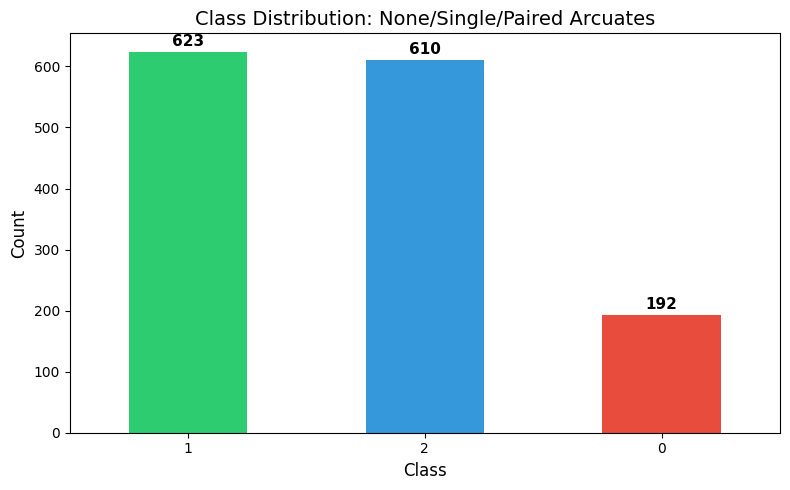


⚠️ Warning: Class imbalance detected! Smallest class is 13.5%
   Consider using class_weight='balanced' or stratified sampling.


In [11]:
# Check class distribution for the target variable
print("Class Distribution for 'None/Single/Paired':")
print("=" * 50)
print("\nAbsolute counts:")
print(df['None/Single/Paired'].value_counts())
print("\nPercentage distribution:")
print(df['None/Single/Paired'].value_counts(normalize=True).round(4) * 100)

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 5))
df['None/Single/Paired'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#3498db', '#e74c3c'])
ax.set_title('Class Distribution: None/Single/Paired Arcuates', fontsize=14)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=0)
for i, v in enumerate(df['None/Single/Paired'].value_counts()):
    ax.text(i, v + 10, str(v), ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Check if there's significant imbalance
min_class_pct = df['None/Single/Paired'].value_counts(normalize=True).min() * 100
if min_class_pct < 15:
    print(f"\n⚠️ Warning: Class imbalance detected! Smallest class is {min_class_pct:.1f}%")
    print("   Consider using class_weight='balanced' or stratified sampling.")
else:
    print(f"\n✓ Classes are reasonably balanced (smallest class: {min_class_pct:.1f}%)")

In [12]:
# ============================================================================
# GPU DETECTION AND CONFIGURATION
# ============================================================================
print("=" * 70)
print("XGBoost GPU Configuration")
print("=" * 70)
print(f"XGBoost version: {xgb.__version__}")

# Detect GPU availability
def get_xgb_device_params():
    """Detect GPU and return appropriate XGBoost device parameters."""
    try:
        # Test if GPU is available by attempting a small training run
        test_data = xgb.DMatrix(np.array([[1, 2], [3, 4]]), label=[0, 1])
        test_params = {'tree_method': 'hist', 'device': 'cuda', 'verbosity': 0}
        xgb.train(test_params, test_data, num_boost_round=1)
        print("✓ CUDA GPU detected and available!")
        return {'tree_method': 'hist', 'device': 'cuda'}
    except Exception as e:
        print(f"✗ GPU not available: {e}")
        print("  Falling back to CPU (tree_method='hist')")
        return {'tree_method': 'hist'}

# Get device parameters (will be used in all models)
xgb_device_params = get_xgb_device_params()
print(f"\nDevice parameters for all models: {xgb_device_params}")

XGBoost GPU Configuration
XGBoost version: 3.1.2


✓ CUDA GPU detected and available!

Device parameters for all models: {'tree_method': 'hist', 'device': 'cuda'}


In [13]:
# MODEL 1: Prepare data for predicting None/Single/Paired arcuates
# Define columns and drop rows with missing values
# 6 features (Laterality removed - low permutation importance)
model1_cols = ['Age', 'Barrett Integrated-K magnitude (D)', 'BIK_axis_cos', 
               'BIK_axis_sin', 'deltaTK_IOL700_cyl_atBIKaxis', 'Manifest_cyl_at_BIKaxis',
               'None/Single/Paired']
model1_df = df[model1_cols].dropna()
print(f"Model 1 dataset size after dropping NaN: {len(model1_df)} samples (dropped {len(df) - len(model1_df)} rows)")

# Separate features and target
X1 = model1_df.drop(columns=['None/Single/Paired'])
y1 = model1_df['None/Single/Paired']

# Encode the target variable
label_encoder1 = LabelEncoder()
y1_encoded = label_encoder1.fit_transform(y1)
print(f"\nTarget classes: {label_encoder1.classes_}")
print(f"Encoded as: {dict(zip(label_encoder1.classes_, range(len(label_encoder1.classes_))))}")

print(f"\nFeature columns: {list(X1.columns)}")

Model 1 dataset size after dropping NaN: 1420 samples (dropped 5 rows)

Target classes: [0 1 2]
Encoded as: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2}

Feature columns: ['Age', 'Barrett Integrated-K magnitude (D)', 'BIK_axis_cos', 'BIK_axis_sin', 'deltaTK_IOL700_cyl_atBIKaxis', 'Manifest_cyl_at_BIKaxis']


In [14]:
# MODEL 1: Train/Test Split and DMatrix Setup
print("=" * 70)
print("MODEL 1: Setup with Native xgb.train() API")
print("=" * 70)

# Create stratified train/test split
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1_encoded, test_size=0.2, random_state=42, stratify=y1_encoded
)

print(f"Training set: {len(X1_train)} samples")
print(f"Test set: {len(X1_test)} samples")

# Convert to DMatrix format for native XGBoost API
print("\nConverting to DMatrix format...")
dtrain1 = xgb.DMatrix(X1_train, label=y1_train)
dtest1 = xgb.DMatrix(X1_test, label=y1_test)
dfull1 = xgb.DMatrix(X1, label=y1_encoded)
print(f"  Training DMatrix: {dtrain1.num_row()} samples, {dtrain1.num_col()} features")
print(f"  Test DMatrix: {dtest1.num_row()} samples")

# Define Model 1 parameters (with GPU support if available)
model1_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'eval_metric': 'mlogloss',
    **xgb_device_params  # GPU or CPU based on detection
}

print(f"\nModel 1 Parameters:")
for k, v in model1_params.items():
    print(f"  {k}: {v}")

MODEL 1: Setup with Native xgb.train() API
Training set: 1136 samples
Test set: 284 samples

Converting to DMatrix format...
  Training DMatrix: 1136 samples, 6 features
  Test DMatrix: 284 samples

Model 1 Parameters:
  objective: multi:softmax
  num_class: 3
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  seed: 42
  eval_metric: mlogloss
  tree_method: hist
  device: cuda


In [15]:
# MODEL 1: Use pre-determined optimal boosting rounds
# (Optimal rounds found via prior CV analysis: 45 rounds, CV Log Loss: 0.6522)
optimal_rounds1 = 45
print(f"Using optimal boosting rounds: {optimal_rounds1}")

Using optimal boosting rounds: 45


MODEL 1: Training with Native xgb.train()


Model trained with 35 iterations (best iteration)

Test Set Performance:
  Accuracy: 0.6937
  F1 Macro: 0.6113


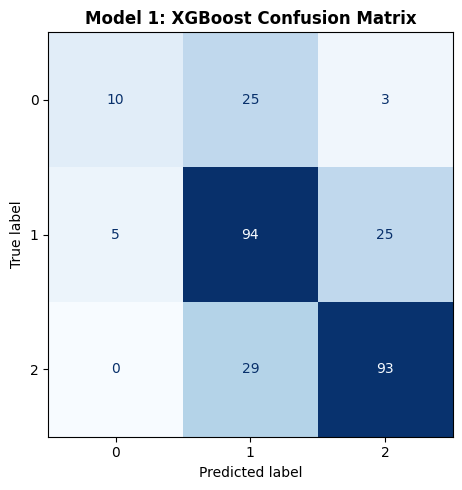


Model 1 training complete.


In [16]:
# MODEL 1: Train with native xgb.train() and evaluate
print("=" * 70)
print("MODEL 1: Training with Native xgb.train()")
print("=" * 70)

# Train the model with optimal rounds
model1 = xgb.train(
    params=model1_params,
    dtrain=dtrain1,
    num_boost_round=optimal_rounds1,
    evals=[(dtrain1, 'train'), (dtest1, 'test')],
    early_stopping_rounds=50,
    verbose_eval=False
)

print(f"Model trained with {model1.best_iteration} iterations (best iteration)")

# Generate predictions
y1_pred = model1.predict(dtest1).astype(int)

# Calculate metrics
acc1 = accuracy_score(y1_test, y1_pred)
f1_1 = f1_score(y1_test, y1_pred, average='macro')

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc1:.4f}")
print(f"  F1 Macro: {f1_1:.4f}")

# Display confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y1_test, y1_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder1.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Model 1: XGBoost Confusion Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nModel 1 training complete.")

In [17]:
# MODEL 1: Classification Report
print("=" * 70)
print("MODEL 1: Classification Report - Test Set")
print("=" * 70)

# Convert class labels to strings for readability
target_names1 = ['None (0)', 'Single (1)', 'Paired (2)']
print(classification_report(y1_test, y1_pred, target_names=target_names1))

MODEL 1: Classification Report - Test Set
              precision    recall  f1-score   support

    None (0)       0.67      0.26      0.38        38
  Single (1)       0.64      0.76      0.69       124
  Paired (2)       0.77      0.76      0.77       122

    accuracy                           0.69       284
   macro avg       0.69      0.59      0.61       284
weighted avg       0.70      0.69      0.68       284



MODEL 1: Feature Importance


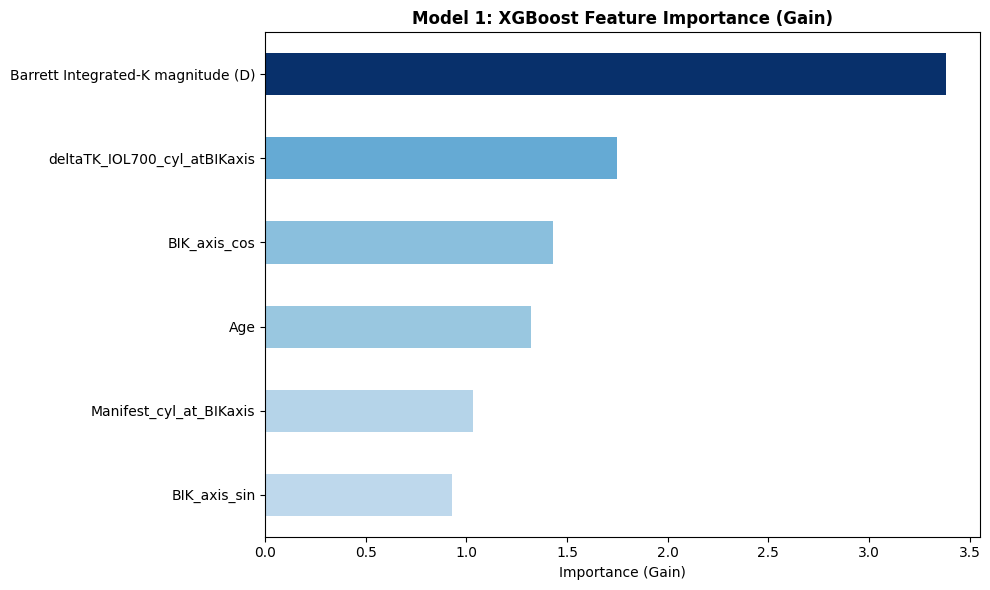


Feature Importance Ranking:
--------------------------------------------------
  Barrett Integrated-K magnitude (D): 3.3829
  deltaTK_IOL700_cyl_atBIKaxis: 1.7482
  BIK_axis_cos: 1.4306
  Age: 1.3207
  Manifest_cyl_at_BIKaxis: 1.0304
  BIK_axis_sin: 0.9257


In [18]:
# MODEL 1: Feature Importance
print("=" * 70)
print("MODEL 1: Feature Importance")
print("=" * 70)

# Get feature importance from native xgb model
importance1 = model1.get_score(importance_type='gain')

# Create DataFrame for plotting
feat_imp_df1 = pd.DataFrame({
    'Feature': list(importance1.keys()),
    'Importance': list(importance1.values())
}).sort_values('Importance', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Blues(feat_imp_df1['Importance'] / feat_imp_df1['Importance'].max())
feat_imp_df1.plot(kind='barh', x='Feature', y='Importance', ax=ax, 
                  legend=False, color=colors)
ax.set_title('Model 1: XGBoost Feature Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_xlabel('Importance (Gain)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Print ranked features
print("\nFeature Importance Ranking:")
print("-" * 50)
for idx, row in feat_imp_df1.sort_values('Importance', ascending=False).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

MODEL 1: Permutation Importance Analysis

Calculating permutation importance (this may take a moment)...


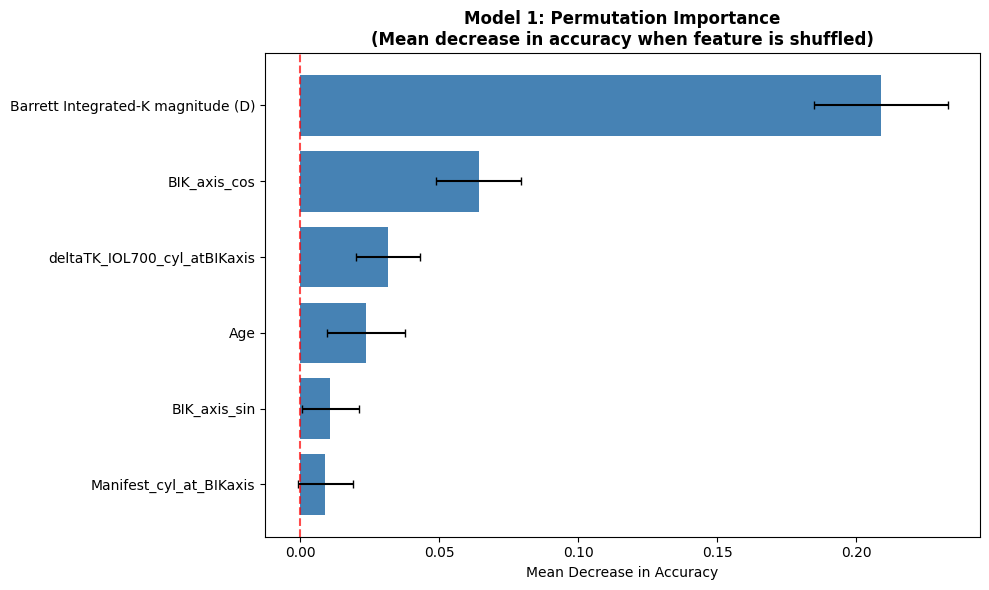


Permutation Importance Ranking:
----------------------------------------------------------------------
Feature                                         Mean Δ Acc        Std
----------------------------------------------------------------------
  Barrett Integrated-K magnitude (D)              0.2088    0.0241
  BIK_axis_cos                                    0.0642    0.0151
  deltaTK_IOL700_cyl_atBIKaxis                    0.0317    0.0114
  Age                                             0.0238    0.0141
  BIK_axis_sin                                    0.0109    0.0102
  Manifest_cyl_at_BIKaxis                         0.0090    0.0099


In [19]:
# MODEL 1: Permutation Importance Analysis (manual calculation for native Booster)
print("=" * 70)
print("MODEL 1: Permutation Importance Analysis")
print("=" * 70)
print("\nCalculating permutation importance (this may take a moment)...")

# Manual permutation importance for native xgb.Booster
n_repeats = 30
baseline_acc = accuracy_score(y1_test, model1.predict(dtest1).astype(int))

perm_results = {'Feature': [], 'Importance_Mean': [], 'Importance_Std': []}

for col_idx, col_name in enumerate(X1.columns):
    scores = []
    for _ in range(n_repeats):
        # Create a copy of test data
        X1_test_perm = X1_test.copy()
        # Shuffle the column
        X1_test_perm[col_name] = np.random.permutation(X1_test_perm[col_name].values)
        # Create DMatrix and predict
        dtest_perm = xgb.DMatrix(X1_test_perm, label=y1_test)
        y_pred_perm = model1.predict(dtest_perm).astype(int)
        # Calculate accuracy decrease
        perm_acc = accuracy_score(y1_test, y_pred_perm)
        scores.append(baseline_acc - perm_acc)
    
    perm_results['Feature'].append(col_name)
    perm_results['Importance_Mean'].append(np.mean(scores))
    perm_results['Importance_Std'].append(np.std(scores))

# Create DataFrame
perm_imp_df1 = pd.DataFrame(perm_results).sort_values('Importance_Mean', ascending=True)

# Plot permutation importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(perm_imp_df1['Feature'], perm_imp_df1['Importance_Mean'], 
        xerr=perm_imp_df1['Importance_Std'], color='steelblue', capsize=3)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax.set_title('Model 1: Permutation Importance\n(Mean decrease in accuracy when feature is shuffled)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Mean Decrease in Accuracy')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Print ranked features with interpretation
print("\nPermutation Importance Ranking:")
print("-" * 70)
print(f"{'Feature':<45} {'Mean Δ Acc':>12} {'Std':>10}")
print("-" * 70)
for idx, row in perm_imp_df1.sort_values('Importance_Mean', ascending=False).iterrows():
    indicator = ""
    if row['Importance_Mean'] < 0:
        indicator = " ← potentially harmful"
    elif row['Importance_Mean'] < 0.005:
        indicator = " ← low importance"
    print(f"  {row['Feature']:<43} {row['Importance_Mean']:>10.4f}  {row['Importance_Std']:>8.4f}{indicator}")

In [20]:
# MODEL 2: Predict LRI length for SINGLE arcuate cases only
# Target: LRI length (from either 'LRI length 1' or 'LRI length 2', whichever is non-zero)

print("=" * 70)
print("MODEL 2: Single Arcuate LRI Length Prediction")
print("=" * 70)

# Filter for single arcuate cases only (None/Single/Paired = 1)
df_single = df[df['None/Single/Paired'] == 1].copy()
print(f"\nFiltered to single arcuate cases: {len(df_single)} samples")

# ============================================================================
# DATA VALIDATION: Ensure exactly one LRI length is non-zero for each case
# ============================================================================
print("\n" + "-" * 50)
print("Data Validation for Single Arcuate Cases:")
print("-" * 50)

# Check for cases where BOTH LRI lengths are non-zero (should not happen for single arcuate)
both_nonzero = df_single[(df_single['LRI length 1'] != 0) & (df_single['LRI length 2'] != 0)]
print(f"  Cases with BOTH LRI lengths non-zero: {len(both_nonzero)}")
if len(both_nonzero) > 0:
    print(f"  ⚠️ WARNING: These cases have both LRI lengths filled - may be data errors:")
    print(both_nonzero[['LRI length 1', 'LRI length 2']].head(10))

# Check for cases where BOTH LRI lengths are zero (should not happen for single arcuate)
both_zero = df_single[(df_single['LRI length 1'] == 0) & (df_single['LRI length 2'] == 0)]
print(f"  Cases with BOTH LRI lengths zero: {len(both_zero)}")
if len(both_zero) > 0:
    print(f"  ⚠️ WARNING: These cases have no LRI length - may be data errors")

# Check cases where exactly one is non-zero (expected)
only_lri1 = df_single[(df_single['LRI length 1'] != 0) & (df_single['LRI length 2'] == 0)]
only_lri2 = df_single[(df_single['LRI length 1'] == 0) & (df_single['LRI length 2'] != 0)]
print(f"  Cases with only LRI length 1 non-zero: {len(only_lri1)}")
print(f"  Cases with only LRI length 2 non-zero: {len(only_lri2)}")
print(f"  Total valid single arcuate cases: {len(only_lri1) + len(only_lri2)}")

if len(both_nonzero) == 0 and len(both_zero) == 0:
    print("\n✓ Data validation PASSED: Each single arcuate case has exactly one non-zero LRI length")
else:
    print("\n⚠️ Data validation WARNING: Some cases may need review")

# ============================================================================
# Create target variable: take whichever LRI length is non-zero
# ============================================================================
def get_single_lri_length(row):
    if row['LRI length 1'] != 0 and row['LRI length 2'] != 0:
        # Both non-zero: use LRI length 1 but flag it
        return row['LRI length 1']
    elif row['LRI length 1'] != 0:
        return row['LRI length 1']
    elif row['LRI length 2'] != 0:
        return row['LRI length 2']
    else:
        return np.nan  # Both zero

df_single['LRI_length_target'] = df_single.apply(get_single_lri_length, axis=1)

# Check target distribution
print("\nLRI Length Target Distribution:")
print(df_single['LRI_length_target'].value_counts().sort_index())
print(f"\nMean LRI length: {df_single['LRI_length_target'].mean():.2f}")
print(f"Std LRI length: {df_single['LRI_length_target'].std():.2f}")

MODEL 2: Single Arcuate LRI Length Prediction

Filtered to single arcuate cases: 623 samples

--------------------------------------------------
Data Validation for Single Arcuate Cases:
--------------------------------------------------
  Cases with BOTH LRI lengths non-zero: 0
  Cases with BOTH LRI lengths zero: 0
  Cases with only LRI length 1 non-zero: 521
  Cases with only LRI length 2 non-zero: 102
  Total valid single arcuate cases: 623

✓ Data validation PASSED: Each single arcuate case has exactly one non-zero LRI length

LRI Length Target Distribution:
LRI_length_target
15      1
18      1
20     44
21     12
22     30
23     35
24     25
25     24
26     17
27     27
28     40
29     30
30    107
31      6
32     49
33     12
34      8
35     64
36     18
37     19
38     17
39      1
40     16
45     20
Name: count, dtype: int64

Mean LRI length: 29.60
Std LRI length: 6.00


In [21]:
# MODEL 2: Prepare features and target
# Removed WTW (mm) - had negative permutation importance (-0.0422)
# Barrett Integrated-K magnitude is the only monotonically increasing feature
# deltaTK_IOL700_cyl_atBIKaxis is included as a feature but NOT designated as monotonic

model2_feature_cols = [
    'Age', 
    'Barrett Integrated-K magnitude (D)', 
    'BIK_axis_cos', 
    'BIK_axis_sin', 
    'deltaK_IOL700_cyl_atBIKaxis', 
    'deltaTK_IOL700_cyl_atBIKaxis',
    'PostAstig_IOL700_cyl_atBIKaxis',
    'Pentacam_cyl_atBIKaxis',
    'Axial length (mm)'
]

model2_cols = model2_feature_cols + ['LRI_length_target']
model2_df = df_single[model2_cols].dropna()
print(f"Model 2 dataset size after dropping NaN: {len(model2_df)} samples (dropped {len(df_single) - len(model2_df)} rows)")

# Separate features and target
X2 = model2_df.drop(columns=['LRI_length_target'])
y2 = model2_df['LRI_length_target']

# No categorical features to encode (Laterality was dropped from Model 2)
print(f"\nFeature columns: {list(X2.columns)}")
print(f"Target: LRI_length_target (continuous)")
print(f"\nFeature statistics:")
X2.describe().round(3)

Model 2 dataset size after dropping NaN: 617 samples (dropped 6 rows)

Feature columns: ['Age', 'Barrett Integrated-K magnitude (D)', 'BIK_axis_cos', 'BIK_axis_sin', 'deltaK_IOL700_cyl_atBIKaxis', 'deltaTK_IOL700_cyl_atBIKaxis', 'PostAstig_IOL700_cyl_atBIKaxis', 'Pentacam_cyl_atBIKaxis', 'Axial length (mm)']
Target: LRI_length_target (continuous)

Feature statistics:


,Age,Barrett Integrated-K magnitude (D),BIK_axis_cos,BIK_axis_sin,deltaK_IOL700_cyl_atBIKaxis,deltaTK_IOL700_cyl_atBIKaxis,PostAstig_IOL700_cyl_atBIKaxis,Pentacam_cyl_atBIKaxis,Axial length (mm)
count,617.00,617.000,617.000,617.000,617.000,617.000,617.000,617.000,617.000
mean,64.81,0.419,-0.391,0.027,0.401,0.301,-0.048,0.415,24.088
std,8.41,0.225,0.657,0.646,0.269,0.317,0.244,0.303,1.406
min,33.00,0.000,-1.000,-1.000,-0.845,-1.011,-0.667,-0.559,20.800
25%,59.00,0.250,-0.951,-0.559,0.223,0.105,-0.248,0.199,23.100
50%,67.00,0.400,-0.695,0.035,0.386,0.295,-0.052,0.398,23.810
75%,71.00,0.550,0.070,0.643,0.567,0.519,0.150,0.599,24.980
max,86.00,1.200,1.000,1.000,1.289,1.172,0.580,1.699,29.430


In [22]:
# MODEL 2: Setup with Native xgb.train() API and Monotonicity Constraints
print("=" * 70)
print("MODEL 2: Smooth XGBoost with Monotonicity Constraints")
print("=" * 70)

# Train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
print(f"Training set: {len(X2_train)} samples")
print(f"Test set: {len(X2_test)} samples")

# Convert to DMatrix format
print("\nConverting to DMatrix format...")
dtrain2 = xgb.DMatrix(X2_train, label=y2_train)
dtest2 = xgb.DMatrix(X2_test, label=y2_test)
dfull2 = xgb.DMatrix(X2, label=y2)

# Define feature order and monotonicity constraints
# Only Barrett Integrated-K magnitude is monotonically increasing
# deltaTK_IOL700_cyl_atBIKaxis is included but NOT designated as monotonic
print("\nFeature columns and monotonicity constraints:")
print("-" * 65)
feature_constraints = [
    ('Age', 0, 'No constraint'),
    ('Barrett Integrated-K magnitude (D)', 1, 'MONOTONIC INCREASING ↑'),
    ('BIK_axis_cos', 0, 'No constraint (angular)'),
    ('BIK_axis_sin', 0, 'No constraint (angular)'),
    ('deltaK_IOL700_cyl_atBIKaxis', 0, 'No constraint'),
    ('deltaTK_IOL700_cyl_atBIKaxis', 0, 'No constraint (not monotonic)'),
    ('PostAstig_IOL700_cyl_atBIKaxis', 0, 'No constraint'),
    ('Pentacam_cyl_atBIKaxis', 0, 'No constraint'),
    ('Axial length (mm)', 0, 'No constraint')
]
for i, (feat, constraint, desc) in enumerate(feature_constraints):
    print(f"  [{i}] {feat:<40} → {desc}")

# Define smooth parameters with monotonicity (only Barrett Integrated-K) and GPU support
model2_params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'reg_alpha': 0.5,
    'reg_lambda': 3.0,
    'gamma': 0.1,
    'min_child_weight': 5,
    'seed': 42,
    'monotone_constraints': (0, 1, 0, 0, 0, 0, 0, 0, 0),
    **xgb_device_params  # GPU 
}

MODEL 2: Smooth XGBoost with Monotonicity Constraints
Training set: 493 samples
Test set: 124 samples

Converting to DMatrix format...

Feature columns and monotonicity constraints:
-----------------------------------------------------------------
  [0] Age                                      → No constraint
  [1] Barrett Integrated-K magnitude (D)       → MONOTONIC INCREASING ↑
  [2] BIK_axis_cos                             → No constraint (angular)
  [3] BIK_axis_sin                             → No constraint (angular)
  [4] deltaK_IOL700_cyl_atBIKaxis              → No constraint
  [5] deltaTK_IOL700_cyl_atBIKaxis             → No constraint (not monotonic)
  [6] PostAstig_IOL700_cyl_atBIKaxis           → No constraint
  [7] Pentacam_cyl_atBIKaxis                   → No constraint
  [8] Axial length (mm)                        → No constraint


In [23]:
# MODEL 2: Use pre-determined optimal boosting rounds and Train
# (Optimal rounds found via prior CV analysis: 180 rounds, CV RMSE: 4.9021, CV MAE: 3.8516)
optimal_rounds2 = 180
print(f"Using optimal boosting rounds: {optimal_rounds2}")

print("\n" + "=" * 70)
print("MODEL 2: Training")
print("=" * 70)

model2 = xgb.train(
    params=model2_params,
    dtrain=dtrain2,
    num_boost_round=optimal_rounds2,
    evals=[(dtrain2, 'train'), (dtest2, 'test')],
    early_stopping_rounds=30,
    verbose_eval=False
)

print(f"Model trained with {model2.best_iteration} iterations")

# Generate predictions and evaluate
y2_pred = model2.predict(dtest2)
r2_2 = r2_score(y2_test, y2_pred)
rmse_2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
mae_2 = mean_absolute_error(y2_test, y2_pred)

print(f"\nTest Set Performance:")
print(f"  R² Score: {r2_2:.4f}")
print(f"  RMSE: {rmse_2:.4f}")
print(f"  MAE: {mae_2:.4f}")

Using optimal boosting rounds: 180

MODEL 2: Training


Model trained with 116 iterations

Test Set Performance:
  R² Score: 0.2719
  RMSE: 5.0289
  MAE: 3.9388


MODEL 2: Visualization


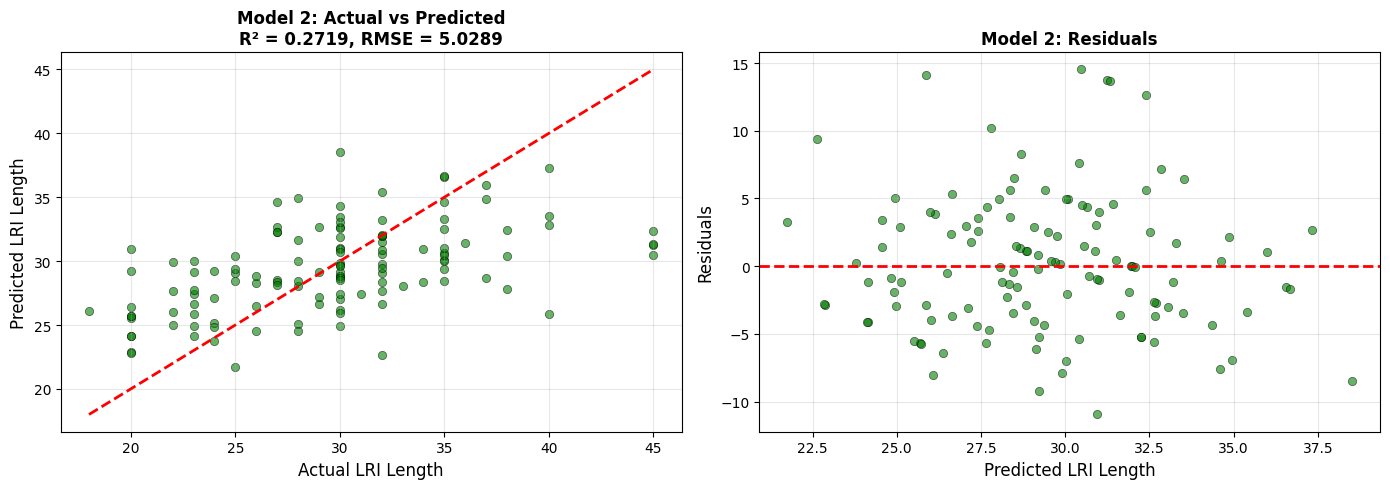


MODEL 2: Monotonicity Verification


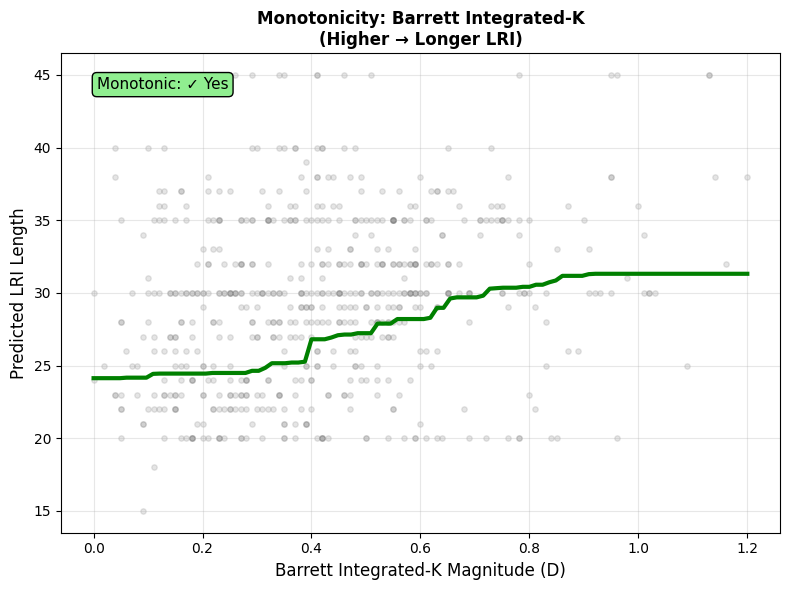


✓ Barrett Integrated-K: Monotonically increasing


In [24]:
# MODEL 2: Visualization and Monotonicity Verification
print("=" * 70)
print("MODEL 2: Visualization")
print("=" * 70)

# Plot actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.scatter(y2_test, y2_pred, alpha=0.6, edgecolors='black', linewidth=0.5, color='green')
ax1.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual LRI Length', fontsize=12)
ax1.set_ylabel('Predicted LRI Length', fontsize=12)
ax1.set_title(f'Model 2: Actual vs Predicted\nR² = {r2_2:.4f}, RMSE = {rmse_2:.4f}', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
residuals2 = y2_test - y2_pred
ax2.scatter(y2_pred, residuals2, alpha=0.6, edgecolors='black', linewidth=0.5, color='green')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted LRI Length', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Model 2: Residuals', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Monotonicity Verification
print("\n" + "=" * 70)
print("MODEL 2: Monotonicity Verification")
print("=" * 70)

n_points = 100
median_features2 = X2.median()

fig, ax = plt.subplots(figsize=(8, 6))

# Barrett Integrated-K magnitude
bik_range = np.linspace(X2['Barrett Integrated-K magnitude (D)'].min(), 
                        X2['Barrett Integrated-K magnitude (D)'].max(), n_points)
pred_data_bik = pd.DataFrame([median_features2.copy() for _ in range(n_points)])
pred_data_bik['Barrett Integrated-K magnitude (D)'] = bik_range
pred_bik = model2.predict(xgb.DMatrix(pred_data_bik[X2.columns]))

ax.plot(bik_range, pred_bik, 'g-', linewidth=3)
ax.scatter(X2['Barrett Integrated-K magnitude (D)'], y2, alpha=0.2, s=15, c='gray')
ax.set_xlabel('Barrett Integrated-K Magnitude (D)', fontsize=12)
ax.set_ylabel('Predicted LRI Length', fontsize=12)
ax.set_title('Monotonicity: Barrett Integrated-K\n(Higher → Longer LRI)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
is_mono_bik = np.all(np.diff(pred_bik) >= -1e-6)
ax.text(0.05, 0.95, f"Monotonic: {'✓ Yes' if is_mono_bik else '✗ No'}", 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen' if is_mono_bik else 'lightcoral'))

plt.tight_layout()
plt.show()

print(f"\n✓ Barrett Integrated-K: {'Monotonically increasing' if is_mono_bik else 'Not monotonic'}")

MODEL 2: Feature Importance


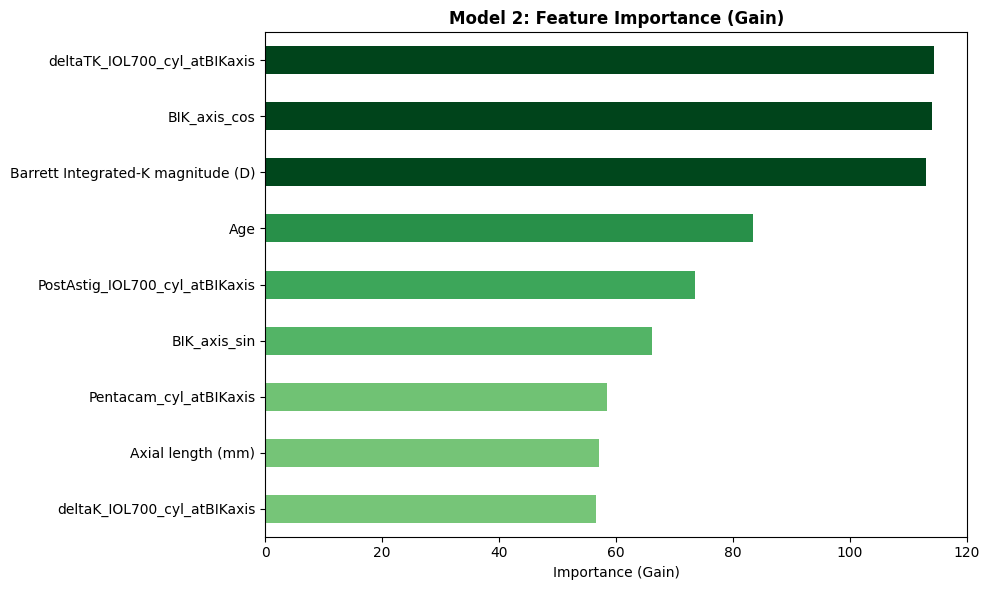


Feature Importance Ranking:
------------------------------------------------------------
  deltaTK_IOL700_cyl_atBIKaxis: 114.3540
  BIK_axis_cos: 114.0433
  Barrett Integrated-K magnitude (D): 113.0662 ← MONOTONIC
  Age: 83.4223
  PostAstig_IOL700_cyl_atBIKaxis: 73.5710
  BIK_axis_sin: 66.1851
  Pentacam_cyl_atBIKaxis: 58.3967
  Axial length (mm): 57.0709
  deltaK_IOL700_cyl_atBIKaxis: 56.6240


In [25]:
# MODEL 2: Feature Importance
print("=" * 70)
print("MODEL 2: Feature Importance")
print("=" * 70)

# Get feature importance
importance2 = model2.get_score(importance_type='gain')

feat_imp_df2 = pd.DataFrame({
    'Feature': list(importance2.keys()),
    'Importance': list(importance2.values())
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Greens(feat_imp_df2['Importance'] / feat_imp_df2['Importance'].max())
feat_imp_df2.plot(kind='barh', x='Feature', y='Importance', ax=ax, legend=False, color=colors)
ax.set_title('Model 2: Feature Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_xlabel('Importance (Gain)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print("-" * 60)
for idx, row in feat_imp_df2.sort_values('Importance', ascending=False).iterrows():
    marker = " ← MONOTONIC" if row['Feature'] == 'Barrett Integrated-K magnitude (D)' else ""
    print(f"  {row['Feature']}: {row['Importance']:.4f}{marker}")

In [26]:
# ============================================================================
# MODEL 3: Predict LRI length for PAIRED arcuate cases
# ============================================================================
# Target: LRI length 1 (when LRI length 1 == LRI length 2, as in paired cases)

print("=" * 70)
print("MODEL 3: Paired Arcuate LRI Length Prediction")
print("=" * 70)

# Filter for paired arcuate cases only (None/Single/Paired = 2)
df_paired = df[df['None/Single/Paired'] == 2].copy()
print(f"\nFiltered to paired arcuate cases: {len(df_paired)} samples")

# Data Validation
print("\n" + "-" * 50)
print("Data Validation for Paired Arcuate Cases:")
print("-" * 50)

# Check if LRI length 1 == LRI length 2 (expected for paired arcuates)
same_length = df_paired[df_paired['LRI length 1'] == df_paired['LRI length 2']]
diff_length = df_paired[df_paired['LRI length 1'] != df_paired['LRI length 2']]
print(f"  Cases with LRI length 1 == LRI length 2: {len(same_length)}")
print(f"  Cases with LRI length 1 != LRI length 2: {len(diff_length)}")

# For paired arcuates, use LRI length 1 as target (should equal LRI length 2)
df_paired['LRI_length_target'] = df_paired['LRI length 1']

# Check target distribution
print(f"\nLRI Length Target Distribution:")
print(df_paired['LRI_length_target'].value_counts().sort_index())
print(f"\nMean LRI length: {df_paired['LRI_length_target'].mean():.2f}")
print(f"Std LRI length: {df_paired['LRI_length_target'].std():.2f}")

MODEL 3: Paired Arcuate LRI Length Prediction

Filtered to paired arcuate cases: 610 samples

--------------------------------------------------
Data Validation for Paired Arcuate Cases:
--------------------------------------------------
  Cases with LRI length 1 == LRI length 2: 610
  Cases with LRI length 1 != LRI length 2: 0

LRI Length Target Distribution:
LRI_length_target
10      8
25      5
27      2
28      5
29     10
30    113
31      3
32     27
33      6
34     14
35    103
36     34
37     55
38     76
39     10
40    131
42      4
43      2
45      2
Name: count, dtype: int64

Mean LRI length: 35.14
Std LRI length: 4.84


In [27]:
# MODEL 3: Prepare features (modified from Model 2 - removed BIK_axis_sin due to negative permutation importance)
print("=" * 70)
print("MODEL 3: Setup with Native xgb.train() API")
print("=" * 70)

# Model 3 features: same as Model 2 but WITHOUT BIK_axis_sin (had negative permutation importance: -0.0381)
model3_feature_cols = [
    'Age', 
    'Barrett Integrated-K magnitude (D)', 
    'BIK_axis_cos', 
    # 'BIK_axis_sin' removed - negative permutation importance
    'deltaK_IOL700_cyl_atBIKaxis', 
    'deltaTK_IOL700_cyl_atBIKaxis',
    'PostAstig_IOL700_cyl_atBIKaxis',
    'Pentacam_cyl_atBIKaxis',
    'Axial length (mm)'
]
print(f"Model 3 uses {len(model3_feature_cols)} features (BIK_axis_sin removed)")

model3_cols = model3_feature_cols + ['LRI_length_target']
model3_df = df_paired[model3_cols].dropna()
print(f"Model 3 dataset size after dropping NaN: {len(model3_df)} samples")

# Separate features and target
X3 = model3_df.drop(columns=['LRI_length_target'])
y3 = model3_df['LRI_length_target']

# Train/test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
print(f"Training set: {len(X3_train)} samples")
print(f"Test set: {len(X3_test)} samples")

# Convert to DMatrix
dtrain3 = xgb.DMatrix(X3_train, label=y3_train)
dtest3 = xgb.DMatrix(X3_test, label=y3_test)
dfull3 = xgb.DMatrix(X3, label=y3)

# Use same parameters as Model 2 but with updated monotonicity constraints (8 features now)
# Order: Age(0), Barrett-K(1), BIK_cos(0), deltaK(0), deltaTK(0), PostAstig(0), Pentacam(0), AxialLen(0)
model3_params = model2_params.copy()
model3_params['monotone_constraints'] = (0, 1, 0, 0, 0, 0, 0, 0)  # Updated for 8 features
print("\nUsing smooth parameters with monotonicity (Barrett-K ↑), BIK_axis_sin removed")

MODEL 3: Setup with Native xgb.train() API
Model 3 uses 8 features (BIK_axis_sin removed)
Model 3 dataset size after dropping NaN: 602 samples
Training set: 481 samples
Test set: 121 samples

Using smooth parameters with monotonicity (Barrett-K ↑), BIK_axis_sin removed


In [28]:
# MODEL 3: Use pre-determined optimal boosting rounds and Train
# (Optimal rounds found via prior CV analysis: 305 rounds, CV RMSE: 4.2002, CV MAE: 2.8975)
optimal_rounds3 = 305
print(f"Using optimal boosting rounds: {optimal_rounds3}")

print("\n" + "=" * 70)
print("MODEL 3: Training")
print("=" * 70)

model3 = xgb.train(
    params=model3_params,
    dtrain=dtrain3,
    num_boost_round=optimal_rounds3,
    evals=[(dtrain3, 'train'), (dtest3, 'test')],
    early_stopping_rounds=30,
    verbose_eval=False
)

print(f"Model trained with {model3.best_iteration} iterations")

# Generate predictions and evaluate
y3_pred = model3.predict(dtest3)
r2_3 = r2_score(y3_test, y3_pred)
rmse_3 = np.sqrt(mean_squared_error(y3_test, y3_pred))
mae_3 = mean_absolute_error(y3_test, y3_pred)

print(f"\nTest Set Performance:")
print(f"  R² Score: {r2_3:.4f}")
print(f"  RMSE: {rmse_3:.4f}")
print(f"  MAE: {mae_3:.4f}")

Using optimal boosting rounds: 305

MODEL 3: Training


Model trained with 172 iterations

Test Set Performance:
  R² Score: 0.3501
  RMSE: 3.7688
  MAE: 2.9146


MODEL 3: Visualization


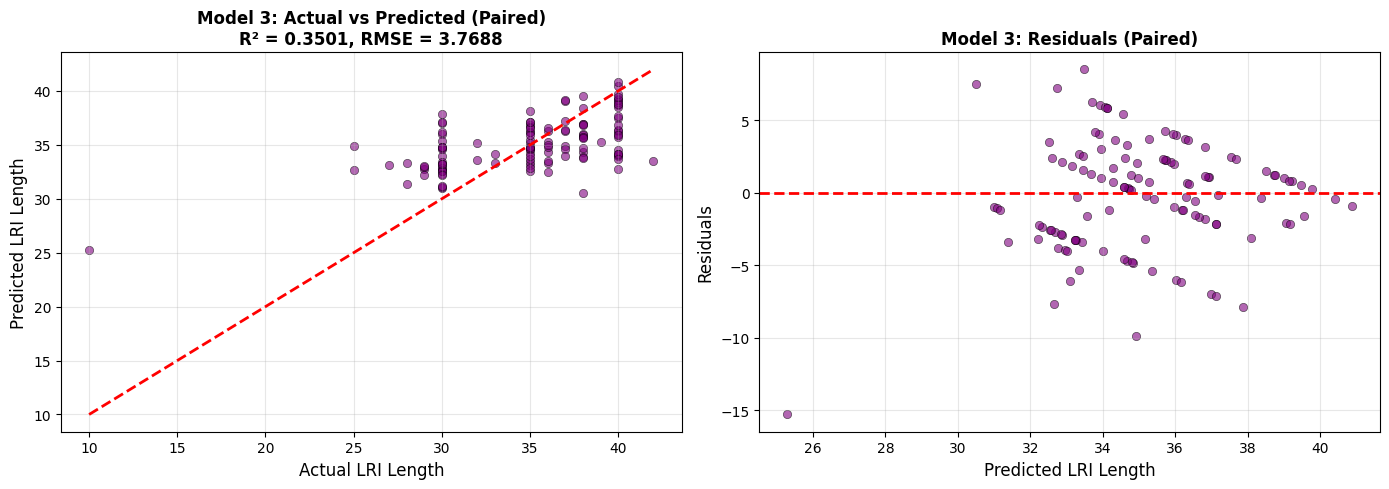


MODEL 3: Monotonicity Verification


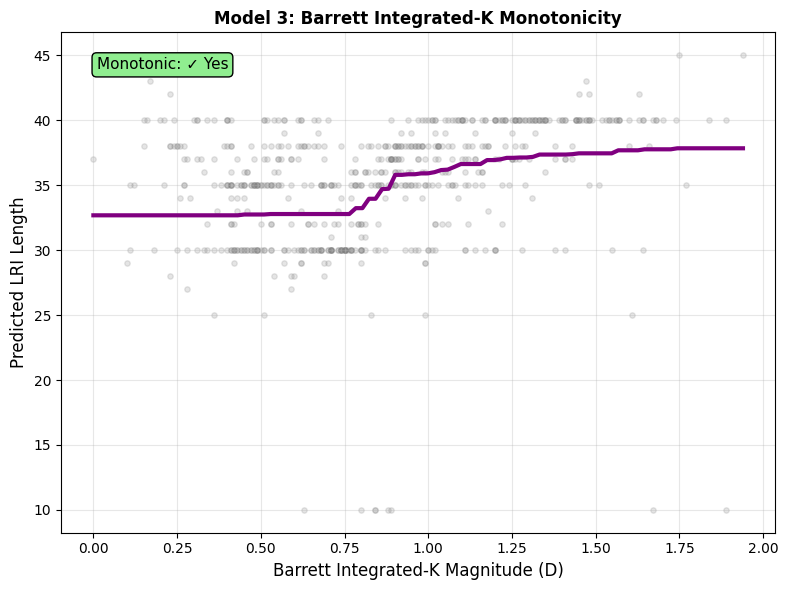


✓ Barrett Integrated-K: Monotonically increasing


In [29]:
# MODEL 3: Visualization and Monotonicity Verification
print("=" * 70)
print("MODEL 3: Visualization")
print("=" * 70)

# Plot actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.scatter(y3_test, y3_pred, alpha=0.6, edgecolors='black', linewidth=0.5, color='purple')
ax1.plot([y3_test.min(), y3_test.max()], [y3_test.min(), y3_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual LRI Length', fontsize=12)
ax1.set_ylabel('Predicted LRI Length', fontsize=12)
ax1.set_title(f'Model 3: Actual vs Predicted (Paired)\nR² = {r2_3:.4f}, RMSE = {rmse_3:.4f}', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
residuals3 = y3_test - y3_pred
ax2.scatter(y3_pred, residuals3, alpha=0.6, edgecolors='black', linewidth=0.5, color='purple')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted LRI Length', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Model 3: Residuals (Paired)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Monotonicity Verification
print("\n" + "=" * 70)
print("MODEL 3: Monotonicity Verification")
print("=" * 70)

median_features3 = X3.median()

fig, ax = plt.subplots(figsize=(8, 6))

# Barrett Integrated-K magnitude
bik_range3 = np.linspace(X3['Barrett Integrated-K magnitude (D)'].min(), 
                         X3['Barrett Integrated-K magnitude (D)'].max(), n_points)
pred_data_bik3 = pd.DataFrame([median_features3.copy() for _ in range(n_points)])
pred_data_bik3['Barrett Integrated-K magnitude (D)'] = bik_range3
pred_bik3 = model3.predict(xgb.DMatrix(pred_data_bik3[X3.columns]))

ax.plot(bik_range3, pred_bik3, 'purple', linewidth=3)
ax.scatter(X3['Barrett Integrated-K magnitude (D)'], y3, alpha=0.2, s=15, c='gray')
ax.set_xlabel('Barrett Integrated-K Magnitude (D)', fontsize=12)
ax.set_ylabel('Predicted LRI Length', fontsize=12)
ax.set_title('Model 3: Barrett Integrated-K Monotonicity', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
is_mono_bik3 = np.all(np.diff(pred_bik3) >= -1e-6)
ax.text(0.05, 0.95, f"Monotonic: {'✓ Yes' if is_mono_bik3 else '✗ No'}", 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen' if is_mono_bik3 else 'lightcoral'))

plt.tight_layout()
plt.show()

print(f"\n✓ Barrett Integrated-K: {'Monotonically increasing' if is_mono_bik3 else 'Not monotonic'}")

MODEL 3: Feature Importance


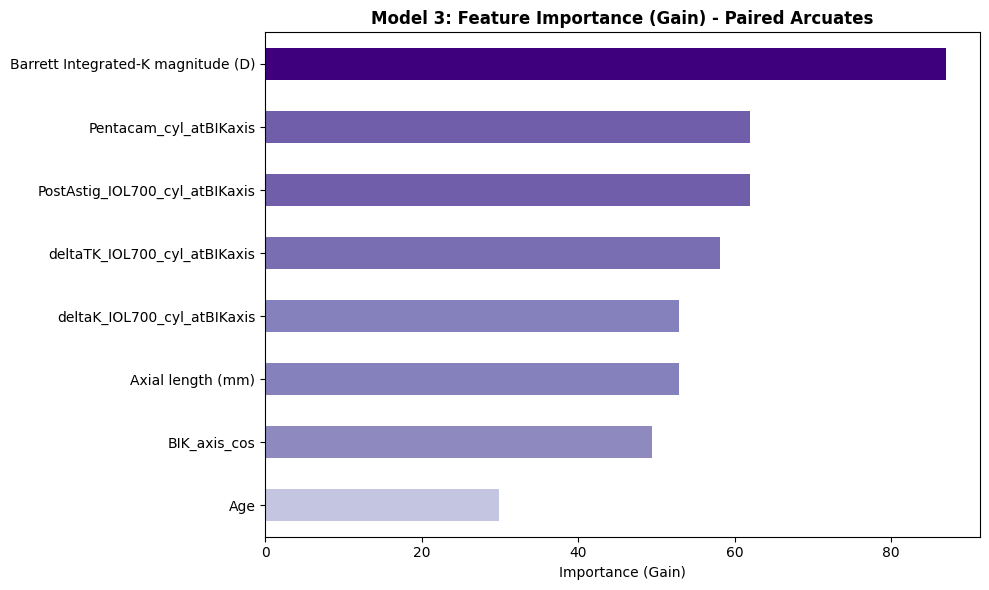


Feature Importance Ranking:
------------------------------------------------------------
  Barrett Integrated-K magnitude (D): 86.9912 ← MONOTONIC
  Pentacam_cyl_atBIKaxis: 61.9978
  PostAstig_IOL700_cyl_atBIKaxis: 61.9811
  deltaTK_IOL700_cyl_atBIKaxis: 58.0765
  deltaK_IOL700_cyl_atBIKaxis: 52.8873
  Axial length (mm): 52.8267
  BIK_axis_cos: 49.4229
  Age: 29.8614


In [30]:
# MODEL 3: Feature Importance
print("=" * 70)
print("MODEL 3: Feature Importance")
print("=" * 70)

# Get feature importance from native xgb model
importance3 = model3.get_score(importance_type='gain')

feat_imp_df3 = pd.DataFrame({
    'Feature': list(importance3.keys()),
    'Importance': list(importance3.values())
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Purples(feat_imp_df3['Importance'] / feat_imp_df3['Importance'].max())
feat_imp_df3.plot(kind='barh', x='Feature', y='Importance', ax=ax, legend=False, color=colors)
ax.set_title('Model 3: Feature Importance (Gain) - Paired Arcuates', fontsize=12, fontweight='bold')
ax.set_xlabel('Importance (Gain)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print("-" * 60)
for idx, row in feat_imp_df3.sort_values('Importance', ascending=False).iterrows():
    marker = " ← MONOTONIC" if row['Feature'] == 'Barrett Integrated-K magnitude (D)' else ""
    print(f"  {row['Feature']}: {row['Importance']:.4f}{marker}")

MODEL 3: Permutation Importance Analysis

Calculating permutation importance (this may take a moment)...


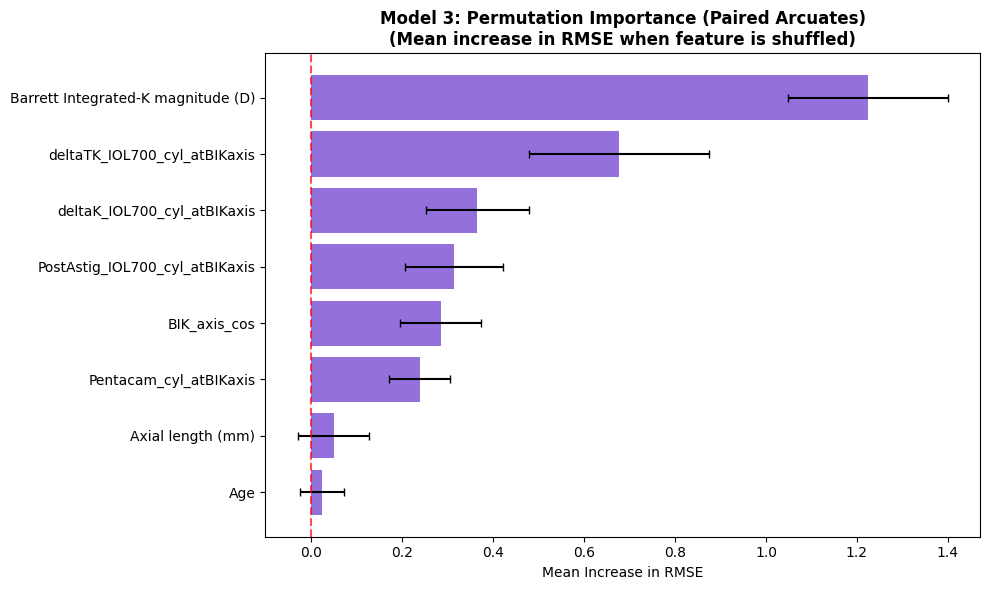


Permutation Importance Ranking:
----------------------------------------------------------------------
Feature                                        Mean Δ RMSE        Std
----------------------------------------------------------------------
  Barrett Integrated-K magnitude (D)              1.2234    0.1758
  deltaTK_IOL700_cyl_atBIKaxis                    0.6766    0.1988
  deltaK_IOL700_cyl_atBIKaxis                     0.3649    0.1127
  PostAstig_IOL700_cyl_atBIKaxis                  0.3134    0.1080
  BIK_axis_cos                                    0.2843    0.0885
  Pentacam_cyl_atBIKaxis                          0.2383    0.0670
  Axial length (mm)                               0.0485    0.0787 ← low importance
  Age                                             0.0236    0.0477 ← low importance


In [31]:
# MODEL 3: Permutation Importance Analysis
print("=" * 70)
print("MODEL 3: Permutation Importance Analysis")
print("=" * 70)
print("\nCalculating permutation importance (this may take a moment)...")

# Manual permutation importance for native xgb.Booster
n_repeats = 30
baseline_rmse3 = np.sqrt(mean_squared_error(y3_test, model3.predict(dtest3)))

perm_results3 = {'Feature': [], 'Importance_Mean': [], 'Importance_Std': []}

for col_idx, col_name in enumerate(X3.columns):
    scores = []
    for _ in range(n_repeats):
        # Create a copy of test data
        X3_test_perm = X3_test.copy()
        # Shuffle the column
        X3_test_perm[col_name] = np.random.permutation(X3_test_perm[col_name].values)
        # Create DMatrix and predict
        dtest_perm3 = xgb.DMatrix(X3_test_perm, label=y3_test)
        y_pred_perm3 = model3.predict(dtest_perm3)
        # Calculate RMSE increase (higher = more important)
        perm_rmse = np.sqrt(mean_squared_error(y3_test, y_pred_perm3))
        scores.append(perm_rmse - baseline_rmse3)
    
    perm_results3['Feature'].append(col_name)
    perm_results3['Importance_Mean'].append(np.mean(scores))
    perm_results3['Importance_Std'].append(np.std(scores))

# Create DataFrame
perm_imp_df3 = pd.DataFrame(perm_results3).sort_values('Importance_Mean', ascending=True)

# Plot permutation importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(perm_imp_df3['Feature'], perm_imp_df3['Importance_Mean'], 
        xerr=perm_imp_df3['Importance_Std'], color='mediumpurple', capsize=3)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax.set_title('Model 3: Permutation Importance (Paired Arcuates)\n(Mean increase in RMSE when feature is shuffled)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Mean Increase in RMSE')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Print ranked features with interpretation
print("\nPermutation Importance Ranking:")
print("-" * 70)
print(f"{'Feature':<45} {'Mean Δ RMSE':>12} {'Std':>10}")
print("-" * 70)
for idx, row in perm_imp_df3.sort_values('Importance_Mean', ascending=False).iterrows():
    indicator = ""
    if row['Importance_Mean'] < 0:
        indicator = " ← potentially harmful"
    elif row['Importance_Mean'] < 0.05:
        indicator = " ← low importance"
    print(f"  {row['Feature']:<43} {row['Importance_Mean']:>10.4f}  {row['Importance_Std']:>8.4f}{indicator}")

In [32]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("=" * 70)
print("FINAL SUMMARY: ALL MODELS")
print("=" * 70)

print("\n📊 MODEL 1: Classification (None/Single/Paired)")
print("-" * 50)
print(f"   Samples: {len(X1)}")
print(f"   Features: {len(X1.columns)}")
print(f"   Accuracy: {acc1:.4f}")
print(f"   F1 Macro: {f1_1:.4f}")
print(f"   Optimal Rounds: {optimal_rounds1}")

print("\n📊 MODEL 2: Single Arcuate LRI Length")
print("-" * 50)
print(f"   Samples: {len(X2)}")
print(f"   Features: {len(X2.columns)}")
print(f"   R² Score: {r2_2:.4f}")
print(f"   RMSE: {rmse_2:.4f}")
print(f"   MAE: {mae_2:.4f}")
print(f"   Optimal Rounds: {optimal_rounds2}")
print(f"   Monotonicity: Barrett-K ↑")

print("\n📊 MODEL 3: Paired Arcuate LRI Length")
print("-" * 50)
print(f"   Samples: {len(X3)}")
print(f"   Features: {len(X3.columns)}")
print(f"   R² Score: {r2_3:.4f}")
print(f"   RMSE: {rmse_3:.4f}")
print(f"   MAE: {mae_3:.4f}")
print(f"   Optimal Rounds: {optimal_rounds3}")
print(f"   Monotonicity: Barrett-K ↑")

print("\n" + "=" * 70)
print("✅ All models use native xgb.train() with DMatrix format")
print("✅ Early stopping prevents overfitting")
print("✅ Models 2 & 3 have monotonicity constraints for clinical validity")
print("=" * 70)

FINAL SUMMARY: ALL MODELS

📊 MODEL 1: Classification (None/Single/Paired)
--------------------------------------------------
   Samples: 1420
   Features: 6
   Accuracy: 0.6937
   F1 Macro: 0.6113
   Optimal Rounds: 45

📊 MODEL 2: Single Arcuate LRI Length
--------------------------------------------------
   Samples: 617
   Features: 9
   R² Score: 0.2719
   RMSE: 5.0289
   MAE: 3.9388
   Optimal Rounds: 180
   Monotonicity: Barrett-K ↑

📊 MODEL 3: Paired Arcuate LRI Length
--------------------------------------------------
   Samples: 602
   Features: 8
   R² Score: 0.3501
   RMSE: 3.7688
   MAE: 2.9146
   Optimal Rounds: 305
   Monotonicity: Barrett-K ↑

✅ All models use native xgb.train() with DMatrix format
✅ Early stopping prevents overfitting
✅ Models 2 & 3 have monotonicity constraints for clinical validity


In [33]:
# ============================================================================
# PRODUCTION MODELS: Train on Full Dataset and Save
# ============================================================================
# For production inference, we retrain on the ENTIRE dataset using the 
# hyperparameters validated during development. This maximizes the data
# available for learning while using the same model configuration.

import os
import json

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

print("=" * 70)
print("PRODUCTION MODELS: Training on Full Dataset")
print("=" * 70)

# ============================================================================
# MODEL 1 PRODUCTION: Classification (None/Single/Paired)
# ============================================================================
print("\n📊 Training Production Model 1 (Classification)...")
print(f"   Using {len(X1)} samples (full dataset)")
print(f"   Optimal rounds: {optimal_rounds1}")

model1_prod = xgb.train(
    params=model1_params,
    dtrain=dfull1,
    num_boost_round=optimal_rounds1,
    verbose_eval=False
)

# Save Model 1
model1_prod.save_model('models/model1_classification.json')
print("   ✓ Saved to models/model1_classification.json")

# ============================================================================
# MODEL 2 PRODUCTION: Single Arcuate LRI Length
# ============================================================================
print("\n📊 Training Production Model 2 (Single Arcuate LRI Length)...")
print(f"   Using {len(X2)} samples (full dataset)")
print(f"   Optimal rounds: {optimal_rounds2}")

model2_prod = xgb.train(
    params=model2_params,
    dtrain=dfull2,
    num_boost_round=optimal_rounds2,
    verbose_eval=False
)

# Save Model 2
model2_prod.save_model('models/model2_single_lri.json')
print("   ✓ Saved to models/model2_single_lri.json")

# ============================================================================
# MODEL 3 PRODUCTION: Paired Arcuate LRI Length
# ============================================================================
print("\n📊 Training Production Model 3 (Paired Arcuate LRI Length)...")
print(f"   Using {len(X3)} samples (full dataset)")
print(f"   Optimal rounds: {optimal_rounds3}")

model3_prod = xgb.train(
    params=model3_params,
    dtrain=dfull3,
    num_boost_round=optimal_rounds3,
    verbose_eval=False
)

# Save Model 3
model3_prod.save_model('models/model3_paired_lri.json')
print("   ✓ Saved to models/model3_paired_lri.json")

print("\n" + "=" * 70)
print("✅ All production models trained and saved!")
print("=" * 70)

PRODUCTION MODELS: Training on Full Dataset

📊 Training Production Model 1 (Classification)...
   Using 1420 samples (full dataset)
   Optimal rounds: 45


   ✓ Saved to models/model1_classification.json

📊 Training Production Model 2 (Single Arcuate LRI Length)...
   Using 617 samples (full dataset)
   Optimal rounds: 180


   ✓ Saved to models/model2_single_lri.json

📊 Training Production Model 3 (Paired Arcuate LRI Length)...
   Using 602 samples (full dataset)
   Optimal rounds: 305


   ✓ Saved to models/model3_paired_lri.json

✅ All production models trained and saved!


In [34]:
# ============================================================================
# Save Model Configuration and Metadata
# ============================================================================
# Save feature columns, label encoder, and other metadata needed for inference

import pickle

# Model 1 metadata
# Convert numpy types to native Python types for JSON serialization
model1_config = {
    'feature_columns': list(X1.columns),
    'target_classes': [int(c) for c in label_encoder1.classes_],
    'class_mapping': {int(k): int(v) for k, v in enumerate(label_encoder1.classes_)},
    'optimal_rounds': int(optimal_rounds1),
    'description': 'Classification: None (0) / Single (1) / Paired (2) arcuates'
}

# Model 2 metadata  
model2_config = {
    'feature_columns': list(X2.columns),
    'optimal_rounds': int(optimal_rounds2),
    'monotonic_features': ['Barrett Integrated-K magnitude (D)'],
    'description': 'Regression: LRI length for SINGLE arcuate cases'
}

# Model 3 metadata
model3_config = {
    'feature_columns': list(X3.columns),
    'optimal_rounds': int(optimal_rounds3),
    'monotonic_features': ['Barrett Integrated-K magnitude (D)'],
    'description': 'Regression: LRI length for PAIRED arcuate cases'
}

# Save all configs
all_configs = {
    'model1': model1_config,
    'model2': model2_config,
    'model3': model3_config
}

with open('models/model_configs.json', 'w') as f:
    json.dump(all_configs, f, indent=2)

# Save label encoder for Model 1 (needed to decode predictions)
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder1, f)

print("Model configurations saved:")
print("\n📄 models/model_configs.json")
print(json.dumps(all_configs, indent=2))

print("\n📄 models/label_encoder.pkl")
print(f"   Classes: {label_encoder1.classes_}")

print("\n" + "=" * 70)
print("✅ All model metadata saved!")
print("=" * 70)

Model configurations saved:

📄 models/model_configs.json
{
  "model1": {
    "feature_columns": [
      "Age",
      "Barrett Integrated-K magnitude (D)",
      "BIK_axis_cos",
      "BIK_axis_sin",
      "deltaTK_IOL700_cyl_atBIKaxis",
      "Manifest_cyl_at_BIKaxis"
    ],
    "target_classes": [
      0,
      1,
      2
    ],
    "class_mapping": {
      "0": 0,
      "1": 1,
      "2": 2
    },
    "optimal_rounds": 45,
    "description": "Classification: None (0) / Single (1) / Paired (2) arcuates"
  },
  "model2": {
    "feature_columns": [
      "Age",
      "Barrett Integrated-K magnitude (D)",
      "BIK_axis_cos",
      "BIK_axis_sin",
      "deltaK_IOL700_cyl_atBIKaxis",
      "deltaTK_IOL700_cyl_atBIKaxis",
      "PostAstig_IOL700_cyl_atBIKaxis",
      "Pentacam_cyl_atBIKaxis",
      "Axial length (mm)"
    ],
    "optimal_rounds": 180,
    "monotonic_features": [
      "Barrett Integrated-K magnitude (D)"
    ],
    "description": "Regression: LRI length for SINGLE arcua